# Rankeo de leads

Imagina que trabajas para un banco y este banco ofrece inversiones a plazo fijo a sus clientes. Como parte de una campaña para ampliar la cantidad de inversiones a plazo fijo que sus clientes han adquirido, la compañía utiliza diversos métodos de contacto, entre los cuales el teléfono es todavía una de las formas más efectivas.

Al banco le encantaría llamar a todos sus clientes, sin embargo, esto no es posible porque el call center no se da abasto y es importante priorizar a quienes hay que llamar para garantizar el máximo número de conversiones.

**Tu tarea es encontrar una forma de clasificar y rankear (ordenar) las llamadas de tal modo que los agentes del centro de llamadas, llame primero a quien tiene más probabilidades de depositar su dinero.**

## Dataset

Este dataset es una versión modificada de Term Deposit Prediction Data Set disponible en Kaggle. https://www.kaggle.com/datasets/brajeshmohapatra/term-deposit-prediction-data-set

## Solución

La empresa tiene información de clientes anteriores que en algún momento han sido contactados en el pasado comprar la inversión en el pasado sin importar si lo compraron o no. Esta información está contenida en el archivo train.csv.

Así mismo, para ayudarte hay un archivo llamado test.csv con datos de otros clientes pero que deberás usar para probar tus resultados.

**Como no tenemos más información más allá de si un cliente compró o no compró, vamos a utilizar las probabilidades que nos de un modelo de clasificación para decidir quién tiene más probabilidades de convertir.**

Este problema se conoce como *lead scoring.*

## Descripción de los datos

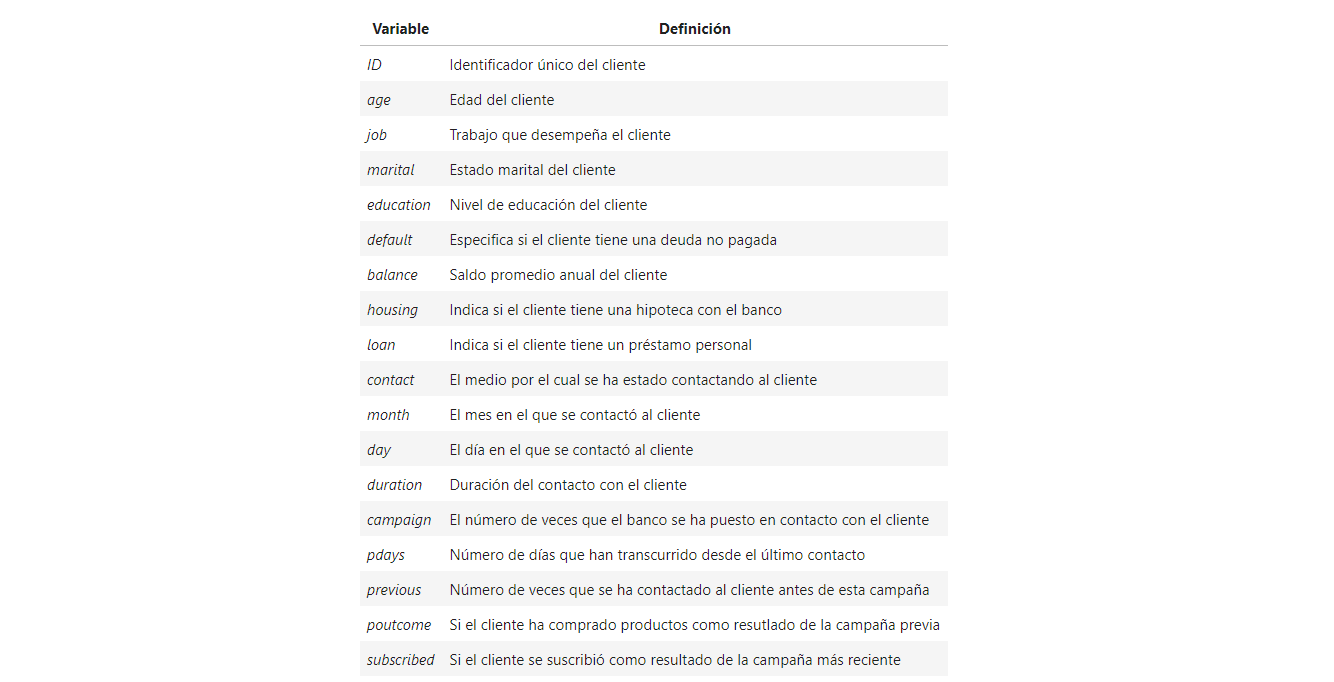

In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv('train.csv')
train.headad()

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,26110,56,admin.,married,unknown,no,1933,no,no,telephone,19,nov,44,2,-1,0,unknown,no
1,40576,31,unknown,married,secondary,no,3,no,no,cellular,20,jul,91,2,-1,0,unknown,no
2,15320,27,services,married,secondary,no,891,yes,no,cellular,18,jul,240,1,-1,0,unknown,no
3,43962,57,management,divorced,tertiary,no,3287,no,no,cellular,22,jun,867,1,84,3,success,yes
4,29842,31,technician,married,secondary,no,119,yes,no,cellular,4,feb,380,1,-1,0,unknown,no


## EDA

In [3]:
from pandas_profiling import ProfileReport
import seaborn as sns

In [4]:
profile = ProfileReport(train, title='Raw Deposit Dataset Analysis', explorative=True)
profile.to_file('deposit-report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Desbalance de clases

Text(0.5, 1.0, 'Target variable distribution\n No: 27932 (88.26%) | Yes: 3715 (11.74%) ')

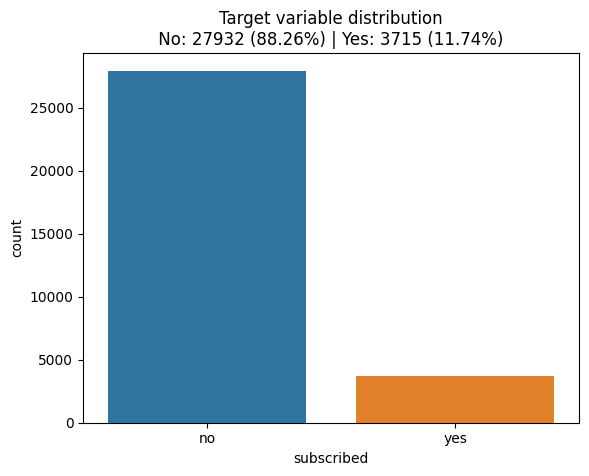

In [7]:
%matplotlib inline

subscribed_proportion = (train['subscribed'].value_counts()).to_dict()
ax = sns.countplot(x = train['subscribed'])
title = ("Target variable distribution\n"
        f" No: {subscribed_proportion['no']} ({(subscribed_proportion['no']/len(train)):0.2%}) |"
        f" Yes: {subscribed_proportion['yes']} ({(subscribed_proportion['yes']/len(train)):0.2%}) ")
ax.set_title(title)

### Relación entre columnas

<AxesSubplot: xlabel='subscribed', ylabel='count'>

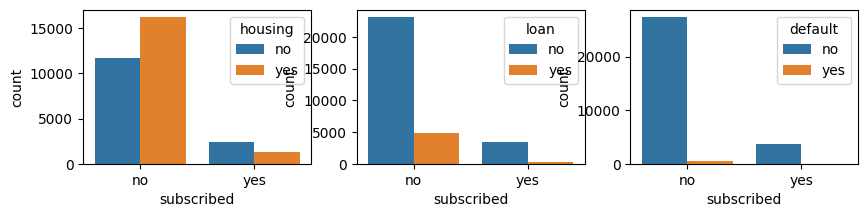

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,3, figsize=(10, 2))

sns.countplot(x='subscribed', hue='housing', data=train, ax=axs[0])
sns.countplot(x='subscribed', hue='loan', data=train, ax=axs[1])
sns.countplot(x='subscribed', hue='default', data=train, ax=axs[2])

## Feature engineering

### Elimina la columna de ID
El ID no contiene ninguna información que nos pueda ayudar a encontrar los mejores resultados puesto que es único para cada cliente.

In [9]:
train.drop(['ID'], axis='columns', inplace=True)

In [10]:
train

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,56,admin.,married,unknown,no,1933,no,no,telephone,19,nov,44,2,-1,0,unknown,no
1,31,unknown,married,secondary,no,3,no,no,cellular,20,jul,91,2,-1,0,unknown,no
2,27,services,married,secondary,no,891,yes,no,cellular,18,jul,240,1,-1,0,unknown,no
3,57,management,divorced,tertiary,no,3287,no,no,cellular,22,jun,867,1,84,3,success,yes
4,31,technician,married,secondary,no,119,yes,no,cellular,4,feb,380,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31642,29,management,single,tertiary,no,0,yes,no,cellular,12,may,116,2,-1,0,unknown,no
31643,53,management,divorced,tertiary,no,380,no,yes,cellular,5,jun,438,2,-1,0,unknown,yes
31644,32,management,single,tertiary,no,312,no,no,cellular,7,aug,37,3,-1,0,unknown,no
31645,57,technician,married,secondary,no,225,yes,no,telephone,15,may,22,7,337,12,failure,no


### One-hot encoding
Variables categóricas

In [11]:
from sklearn.preprocessing import OneHotEncoder

marital_encoder = OneHotEncoder()

In [12]:
marital_encoder.fit(train[['marital']])

OneHotEncoder()

In [13]:
encoded_marital = marital_encoder.transform(train[['marital']])
encoded_marital

<31647x3 sparse matrix of type '<class 'numpy.float64'>'
	with 31647 stored elements in Compressed Sparse Row format>

In [14]:
encoded_marital.toarray()

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [15]:
encoded_marital = pd.DataFrame(encoded_marital.toarray(), columns=marital_encoder.categories_)
encoded_marital['original_value'] = train['marital']
encoded_marital

,divorced,married,single,original_value
0,0.0,1.0,0.0,married
1,0.0,1.0,0.0,married
2,0.0,1.0,0.0,married
3,1.0,0.0,0.0,divorced
4,0.0,1.0,0.0,married
...,...,...,...,...
31642,0.0,0.0,1.0,single
31643,1.0,0.0,0.0,divorced
31644,0.0,0.0,1.0,single
31645,0.0,1.0,0.0,married


### Binnea y codifica la variable edad

In [18]:
from custom_transformers import CutTransformer

In [19]:
age_bin = CutTransformer(bins = [0, 20, 30, 40, 50, 60, 1000], as_str=True)

In [20]:
age_frame = train[['age']].copy()
age_bin.fit(age_frame[['age']])

age_encoded = age_bin.transform(age_frame[['age']])
age_frame['age_encoded'] = age_encoded

In [21]:
age_frame

,age,age_encoded
0,56,"(50, 60]"
1,31,"(30, 40]"
2,27,"(20, 30]"
3,57,"(50, 60]"
4,31,"(30, 40]"
...,...,...
31642,29,"(20, 30]"
31643,53,"(50, 60]"
31644,32,"(30, 40]"
31645,57,"(50, 60]"


In [22]:
age_one_hot_encoder = OneHotEncoder()

In [23]:
age_one_hot_encoder.fit(age_frame[['age_encoded']])

OneHotEncoder()

In [24]:
oh_age = age_one_hot_encoder.transform(age_frame[['age_encoded']]).toarray()

In [25]:
one_hot_encoded_ages = pd.DataFrame(
    oh_age,
    columns=age_one_hot_encoder.categories_
)

In [26]:
pd.merge(age_frame, one_hot_encoded_ages, left_index=True, right_index=True)

,age,age_encoded,"((0, 20],)","((20, 30],)","((30, 40],)","((40, 50],)","((50, 60],)","((60, 1000],)"
0,56,"(50, 60]",0.0,0.0,0.0,0.0,1.0,0.0
1,31,"(30, 40]",0.0,0.0,1.0,0.0,0.0,0.0
2,27,"(20, 30]",0.0,1.0,0.0,0.0,0.0,0.0
3,57,"(50, 60]",0.0,0.0,0.0,0.0,1.0,0.0
4,31,"(30, 40]",0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
31642,29,"(20, 30]",0.0,1.0,0.0,0.0,0.0,0.0
31643,53,"(50, 60]",0.0,0.0,0.0,0.0,1.0,0.0
31644,32,"(30, 40]",0.0,0.0,1.0,0.0,0.0,0.0
31645,57,"(50, 60]",0.0,0.0,0.0,0.0,1.0,0.0


### Escalado de los datos

In [31]:
from sklearn.preprocessing import StandardScaler

In [32]:
balance_scaler = StandardScaler()

In [33]:
balance_scaled = train[['balance']].copy()

In [34]:
balance_scaled['balance_scaled'] = balance_scaler.fit_transform(balance_scaled[['balance']])

In [35]:
balance_scaled

,balance,balance_scaled
0,1933,0.187933
1,3,-0.449397
2,891,-0.156159
3,3287,0.635055
4,119,-0.411091
...,...,...
31642,0,-0.450388
31643,380,-0.324903
31644,312,-0.347358
31645,225,-0.376088


### Convierte "yes" y "no" a enteros 1 y 0

In [36]:
from custom_transformers import YesNoTransformer

yes_no_transformer = YesNoTransformer()

In [37]:
housing_loan_frame = train[['housing', 'loan']].copy()

In [38]:
housing_loan_frame[['housing_mapped', 'loan_mapped']] = yes_no_transformer.fit_transform(housing_loan_frame)

In [39]:
housing_loan_frame

,housing,loan,housing_mapped,loan_mapped
0,no,no,0,0
1,no,no,0,0
2,yes,no,1,0
3,no,no,0,0
4,yes,no,1,0
...,...,...,...,...
31642,yes,no,1,0
31643,no,yes,0,1
31644,no,no,0,0
31645,yes,no,1,0


# Pipeline

## Empaca todos los artefactos en un pipeline
La gestión de los artefactos puede volverse un problema cuando estamos lidiando con múltiples transformadores y estimadores. En nuestro caso tenemos One-Hot encoders, un Cut transformer, escalador estandar...

Una forma de no tener que preocuparnos por elementos individuales es agruparlos todos en un pipeline y almacenarlo todo en conjunto.

In [42]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn import set_config

In [41]:
# One-Hot encode marital status
one_hot_encoded_categoricals = ColumnTransformer([
    (
        'one_hot_encode', # Nombre de la transformación
        OneHotEncoder(), # Transformación a aplicar
        ['marital', 'contact', 'education', 'poutcome'] # Columnas involucradas
    )
])

In [43]:
# Bin and encode age
bin_and_encode_age_pipeline = Pipeline([
    ('bin_age', CutTransformer(bins = [0, 20, 30, 40, 50, 60, 1000], as_str=True)),
    ('encode_age', OneHotEncoder()),
])

bin_and_encode_age = ColumnTransformer([
    (
        'bin_and_encode_age',
        bin_and_encode_age_pipeline,
        ['age']
    )
])

In [44]:
# Scale balance
scale_balance = ColumnTransformer([
    (
        'scale_balance', # Nombre de la transformación
        StandardScaler(), # Transformación a aplicar
        ['balance'] # Columnas involucradas
    )
])

In [45]:
map_housing_loan = ColumnTransformer([
    (
        'map_housing_loan', # Nombre de la transformación
        YesNoTransformer(), # Transformación a aplicar
        ['housing', 'loan', 'default'] # Columnas involucradas
    )
])

In [46]:
# No transformation to thesebbbb values
passthrough = ColumnTransformer([
    (
        'passthrough',
        'passthrough',
        ['campaign', 'pdays', 'duration', 'previous']
    )
])

In [47]:
train

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,56,admin.,married,unknown,no,1933,no,no,telephone,19,nov,44,2,-1,0,unknown,no
1,31,unknown,married,secondary,no,3,no,no,cellular,20,jul,91,2,-1,0,unknown,no
2,27,services,married,secondary,no,891,yes,no,cellular,18,jul,240,1,-1,0,unknown,no
3,57,management,divorced,tertiary,no,3287,no,no,cellular,22,jun,867,1,84,3,success,yes
4,31,technician,married,secondary,no,119,yes,no,cellular,4,feb,380,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31642,29,management,single,tertiary,no,0,yes,no,cellular,12,may,116,2,-1,0,unknown,no
31643,53,management,divorced,tertiary,no,380,no,yes,cellular,5,jun,438,2,-1,0,unknown,yes
31644,32,management,single,tertiary,no,312,no,no,cellular,7,aug,37,3,-1,0,unknown,no
31645,57,technician,married,secondary,no,225,yes,no,telephone,15,may,22,7,337,12,failure,no


### Ensamblar todo el pipeline

In [48]:
feature_pipeline = Pipeline([
    (
        'features',
        FeatureUnion([
            ('one_hot_encode_categoricals', one_hot_encoded_categoricals),
            ('bin_and_encode_age', bin_and_encode_age),
            ('scale_balance', scale_balance),
            ('passthrough', passthrough),
            ('map_housing_loan', map_housing_loan),
        ])
    )
])

In [49]:
from sklearn import set_config

set_config(display = 'diagram')
feature_pipeline

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('one_hot_encode_categoricals',
                                                 ColumnTransformer(transformers=[('one_hot_encode',
                                                                                  OneHotEncoder(),
                                                                                  ['marital',
                                                                                   'contact',
                                                                                   'education',
                                                                                   'poutcome'])])),
                                                ('bin_and_encode_age',
                                                 ColumnTransformer(transformers=[('bin_and_encode_age',
                                                                                  Pipeline(steps=[('bin_age',
                                                                                                   CutTransformer(bins=[0,
                                                                                                                        20,
                                                                                                                        30,
                                                                                                                        40,
                                                                                                                        50,
                                                                                                                        60,
                                                                                                                        1000...
                                                ('scale_balance',
                                                 ColumnTransformer(transformers=[('scale_balance',
                                                                                  StandardScaler(),
                                                                                  ['balance'])])),
                                                ('passthrough',
                                                 ColumnTransformer(transformers=[('passthrough',
                                                                                  'passthrough',
                                                                                  ['campaign',
                                                                                   'pdays',
                                                                                   'duration',
                                                                                   'previous'])])),
                                                ('map_housing_loan',
                                                 ColumnTransformer(transformers=[('map_housing_loan',
                                                                                  YesNoTransformer(),
                                                                                  ['housing',
                                                                                   'loan',
                                                                                   'default'])]))]))])

In [55]:
feature_pipeline.fit(train)

temp_train = pd.DataFrame(feature_pipeline.transform(train).toarray())
temp_train

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.187933,2.0,-1.0,44.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,-0.449397,2.0,-1.0,91.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,-0.156159,1.0,-1.0,240.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.635055,1.0,84.0,867.0,3.0,0.0,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,-0.411091,1.0,-1.0,380.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31642,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,-0.450388,2.0,-1.0,116.0,0.0,1.0,0.0,0.0
31643,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,-0.324903,2.0,-1.0,438.0,0.0,0.0,1.0,0.0
31644,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,-0.347358,3.0,-1.0,37.0,0.0,0.0,0.0,0.0
31645,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,-0.376088,7.0,337.0,22.0,12.0,1.0,0.0,0.0


In [54]:
train.shape

(31647, 17)

### Convierte el target a enteros

In [56]:
subscribed_frame = train[['subscribed']].copy()
subscribed_frame['encoded'] = np.where(subscribed_frame['subscribed'] == 'yes', 1, 0)

subscribed_frame.head(10)

,subscribed,encoded
0,no,0
1,no,0
2,no,0
3,yes,1
4,no,0
5,no,0
6,yes,1
7,no,0
8,no,0
9,no,0


In [57]:
training_target_encoded = np.where(subscribed_frame['subscribed'] == 'yes', 1, 0)

In [58]:
training_target_encoded

array([0, 0, 0, ..., 0, 0, 1])

# Machine learning
### Encuentra los mejores parámetros

In [59]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [60]:
search_pipeline = Pipeline([
    ('feature_pipeline', feature_pipeline),
    ('model', XGBClassifier()) #('model', LogisticRegression())
])

In [64]:
param_grid = {
    "model__n_estimators": [100, 200, 300],
    'model__max_depth': [4, 5, 6],
    'model__subsample': [0.5, 1],
    # 'model__scale_pos_weight': [1, 7.5],
    # 'model__eta': [0.01, 0.1, 0.2, 0.3]
}
search = GridSearchCV(search_pipeline, param_grid, n_jobs=-1, scoring='precision')
_ = search.fit(train, training_target_encoded)

In [63]:
?XGBClassifier

In [65]:
best_params = {key[7:]:value for key, value in search.best_params_.items()}
print("Best parameters:", best_params)
print(f"Best score: {search.best_score_:0.3%}")

Best parameters: {'max_depth': 4, 'n_estimators': 100, 'subsample': 1}
Best score: 63.165%


### Reentrena el mejor modelo con los mejores parámetros
A pesar de que puedes utilizar el modelo entrenado usando search.best_estimator_, es una buena idea **reentrenar** un modelo nuevo **utilizando los mejores parámetros** recien obtenidos y **todos los datos disponibles para entrenamiento.**

In [66]:
inference_pipeline = Pipeline([
    ('feature_pipeline', feature_pipeline),
    ('model', XGBClassifier(**best_params))
])
_ = inference_pipeline.fit(train, training_target_encoded)

In [67]:
predicciones = inference_pipeline.predict(train)

In [68]:
predicciones

array([0, 0, 0, ..., 0, 0, 1])

In [69]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, confusion_matrix

In [70]:
def evaluate(y_true, y_pred):
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    print(confusion_matrix(y_true, y_pred))

    print(f"R:{recall:0.2%} A:{accuracy:0.2%} P:{precision:0.2%}")

In [71]:
evaluate(training_target_encoded, predicciones)

[[27345   587]
 [ 1983  1732]]
R:46.62% A:91.88% P:74.69%


## Evaluando con los datos de prueba

In [72]:
test = pd.read_csv("test.csv")

In [73]:
predicciones_test = inference_pipeline.predict(test)
predicciones_test

evaluate(np.where(test['subscribed'] == 'yes', 1, 0), predicciones_test)

[[11627   363]
 [  953   621]]
R:39.45% A:90.30% P:63.11%


In [74]:
test['subscribed'].value_counts()

no     11990
yes     1574
Name: subscribed, dtype: int64

## Guardando todo el pipeline

In [75]:
import pickle

with open("lead_scoring.pickle", "wb") as wb:
    pickle.dump(inference_pipeline, wb)

## ¿Y el lead scoring?

In [76]:
with open("lead_scoring.pickle", "rb") as rb:
    lead_scoring = pickle.load(rb)

In [81]:
probabilidades = lead_scoring.predict_proba(test)
valores = pd.DataFrame(probabilidades)
valores['pred'] = predicciones_test
valores

,0,1,pred
0,0.999971,0.000029,0
1,0.408961,0.591039,1
2,0.675690,0.324310,0
3,0.993630,0.006370,0
4,0.997793,0.002207,0
...,...,...,...
13559,0.972993,0.027007,0
13560,0.992591,0.007409,0
13561,0.988339,0.011661,0
13562,0.174624,0.825376,1


ℹ️ **predict_proba** regresa un arreglo de tamaño (n_samples, n_classes), en donde las clases están dadas en el orden dictado por **lead_scoring.classes_**

In [78]:
lead_scoring.classes_

array([0, 1])

In [79]:
test['score'] = probabilidades[:, 1] # valores de la columna de 1

In [80]:
test[["ID", "score"]].sort_values('score', ascending=False)

,ID,score
11975,42275,0.973606
6248,45127,0.957878
4557,42711,0.952001
7060,44143,0.948189
2329,44202,0.948115
...,...,...
8509,12074,0.000006
13324,3495,0.000006
4742,23458,0.000006
9641,36051,0.000006


In [82]:
test.sort_values('score', ascending=False)

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed,score
11975,42275,18,student,single,primary,no,608,no,no,cellular,13,nov,210,1,93,1,success,yes,0.973606
6248,45127,54,technician,married,tertiary,no,876,no,no,cellular,27,oct,269,3,541,3,success,yes,0.957878
4557,42711,61,retired,married,secondary,no,86,no,no,cellular,25,jan,639,1,94,1,success,yes,0.952001
7060,44143,55,unknown,married,secondary,no,1157,no,no,cellular,12,jul,289,1,412,2,failure,no,0.948189
2329,44202,35,services,married,secondary,no,2918,no,yes,cellular,16,jul,815,2,407,3,success,yes,0.948115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8509,12074,44,blue-collar,married,primary,no,-312,yes,no,unknown,20,jun,22,3,-1,0,unknown,no,0.000006
13324,3495,55,management,married,unknown,yes,-171,yes,no,unknown,15,may,30,2,-1,0,unknown,no,0.000006
4742,23458,38,technician,married,secondary,no,-104,no,no,cellular,28,aug,13,17,-1,0,unknown,no,0.000006
9641,36051,45,blue-collar,married,secondary,no,-104,yes,no,cellular,11,may,33,12,-1,0,unknown,no,0.000006
